# Creating a LSTM categorical serie predictor for crop usage using Keras


In [1]:
import sys
sys.path.append("../src")

In [27]:
import os
import keras
import keras.backend as K
import numpy as np
import tensorflow as tf
from keras.utils import to_categorical
from sklearn.model_selection import StratifiedShuffleSplit
from keras.models import Model
import pandas as pd
from matplotlib import pyplot as plt

from data import read_crop_list, load_structured_sample
from eval import eval_model_one_hot
from metrics import f1, f1_loss
from models import model_stack_lstm, model_Conv1D, model_Conv1D_LSTM
from training import train, create_training_folder
from keras.utils import plot_model
from training import train, create_training_folder, create_callbacks, step_decay_exp
from keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau

from keras.models import Sequential
from tensorflow.python.keras.layers import Embedding, LSTM, BatchNormalization, Dense, Conv1D, GlobalAveragePooling1D, \
    Dropout, Input, Permute, Concatenate

from training import train, create_training_folder


In [3]:
from training import train, create_training_folder

tf.keras.utils.get_custom_objects()
tf.keras.utils.get_custom_objects()['f1'] = f1
tf.keras.utils.get_custom_objects()['f1_loss'] = f1_loss

# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" # for the notebook tu run on CPU son GPU can be used for training in parallel
# os.environ["CUDA_VISIBLE_DEVICES"] = ""


## Train test datasets

Before training the model, we first have to split data in different groups:
* Train: train the model.
* Test: measure the performance of the train modelo.

We use the StratifiedShuffleSplit to keep the same crop distrution among all the splits.

LSTM networks are stochastic models, so they depend on the initialization parametrs, random state, etc. To avoid over estimating the classifier performance, we should train the model on different splits evaluate the model on each split, so we can get the distribution of the model score and see the variability in its performance.
For simplicity, in this case just one split is used.


In [4]:

df_crops, vocab = read_crop_list()

sample = load_structured_sample()
# sample = load_undersampled_data()
print("Using sample size: {}".format(sample.shape))

y = sample[:, 11]
X = sample[:, 3:11]

# convert y to one-hot enconding
y = to_categorical(y)
print(y.shape)

# Create train/test/validation
# first split data -> train / test
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=0)
# for train_index, test_index in sss.split(X_train, y_train):
#     X_train, X_val = X[train_index], X[test_index]
#     y_train, y_val = y[train_index], y[test_index]

print("===Train/test size: {} ({}%), {}({}%)).".format(len(y_train),round(100*len(y_train)/len(y),2),
                                                       len(y_test),round(100*len(y_test)/len(y),2)))


Using sample size: (31373, 12)
(31373, 27)
===Train/test size: 25098 (80.0%), 6275(20.0%)).


## Model definition
We start creating a basic LSTM model with just one layer adn 64 units.
* The model has an initial Embedding layer responsible for creating the multidimensional representation of the crop codes. Each crop code is encoded in a vector of 20 dimensions. (This number has been chosen from experimentation.
* The second layer, LSTM will learn the patterns in the "sentences"
* The final dense layer will map the LSTM output to each output neuron, it has as many neurons as crop categories.




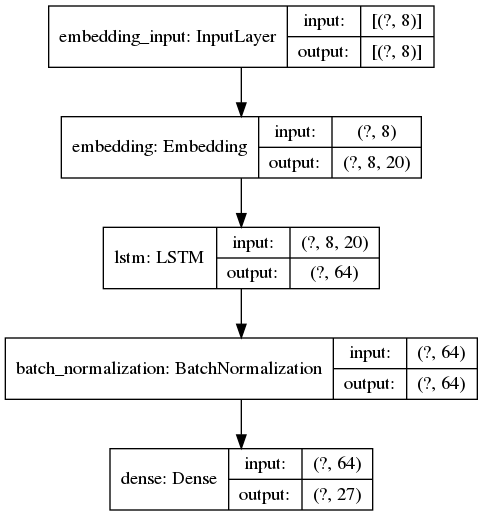

In [5]:
vocab_size = len(np.unique(sample[:, 11])) # number of different crops, 26
sequence_length=8
embedding_size=20 # how many dimesions we want o use to represent each crop code

initializer = tf.keras.initializers.Identity()
model = Sequential()
model.add(Embedding(vocab_size, embedding_size,
                    embeddings_initializer=initializer,
                    input_length=sequence_length))
model.add(LSTM(64))
model.add(BatchNormalization())
model.add(Dense(vocab_size, activation="relu"))


plot_model(model, show_shapes = True)



In [6]:
training_params = {
    'loss': f1_loss,
    # 'loss': 'categorical_crossentropy',
    # 'optimizer': 'rmsprop',
    'optimizer': tf.optimizers.RMSprop(lr=0.001, clipvalue=0.3),
    'metrics': [f1],
    'run_eagerly': False
}
model.compile(**training_params)




In [23]:
def train_evaluate_model(model, tag, X_train, y_train, X_test, y_test, callbacks = None):
    K.clear_session()
    epochs = 100

    folder = create_training_folder("course", tag, add_timestamp=False)
    
    if callbacks is None:
        callbacks = []    
        callbacks.append(CSVLogger('{}/training_history.csv'.format(folder), append=True, separator=';'))
        stopper = keras.callbacks.EarlyStopping(monitor="val_f1",
            # "no longer improving" being defined as "no better than 1e-3 less"
            min_delta=0.001,
            mode="max",
            # "no longer improving" being further defined as "for at least 8 epochs"
            patience=15, verbose=1)
        callbacks.append(stopper)


    model.fit(X_train, y_train, epochs=epochs, verbose=2, validation_data=(X_test, y_test), callbacks = callbacks)

    loss = model.evaluate(X_test, y_test, verbose=0)

    print("Loss on test data: {}".format(loss))
    return folder
    

In [8]:

folder = train_evaluate_model(model, "lstm_v1", X_train, y_train, X_test, y_test)
    

Epoch 1/100
785/785 - 3s - loss: 0.5135 - f1: 0.4925 - val_loss: 0.4595 - val_f1: 0.5420
Epoch 2/100
785/785 - 3s - loss: 0.3706 - f1: 0.6307 - val_loss: 0.3959 - val_f1: 0.6029
Epoch 3/100
785/785 - 3s - loss: 0.3412 - f1: 0.6587 - val_loss: 0.3756 - val_f1: 0.6213
Epoch 4/100
785/785 - 3s - loss: 0.3277 - f1: 0.6723 - val_loss: 0.3643 - val_f1: 0.6327
Epoch 5/100
785/785 - 3s - loss: 0.3113 - f1: 0.6882 - val_loss: 0.3388 - val_f1: 0.6585
Epoch 6/100
785/785 - 3s - loss: 0.3064 - f1: 0.6933 - val_loss: 0.3351 - val_f1: 0.6621
Epoch 7/100
785/785 - 3s - loss: 0.2981 - f1: 0.7019 - val_loss: 0.3331 - val_f1: 0.6648
Epoch 8/100
785/785 - 3s - loss: 0.2858 - f1: 0.7137 - val_loss: 0.3237 - val_f1: 0.6738
Epoch 9/100
785/785 - 3s - loss: 0.2878 - f1: 0.7114 - val_loss: 0.3195 - val_f1: 0.6778
Epoch 10/100
785/785 - 3s - loss: 0.2793 - f1: 0.7203 - val_loss: 0.3200 - val_f1: 0.6765
Epoch 11/100
785/785 - 3s - loss: 0.2685 - f1: 0.7309 - val_loss: 0.3143 - val_f1: 0.6829
Epoch 12/100
785/78

Best f1-score on test dataset: **0.7120**

In [9]:
BASE_FOLDER = "../results/"

def plot_results(training_folder, metric = None):
    if not metric:
        metric = "f1"
    path = os.path.join(BASE_FOLDER, training_folder, "training_history.csv")
    df = pd.read_csv(path, sep=";")

    print("Results file: {}".format(training_folder))
    print("Last 10 records avg: ")
    print(df.tail(10).mean())

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    plt.title(training_folder)
    axs[0].plot(df["loss"], label='loss')
    axs[0].plot(df["val_loss"], label='val_loss')
    axs[0].legend(loc="upper right")
    axs[1].plot(df[metric], label=metric)
    axs[1].plot(df["val_"+metric], label='val_'+metric)
    axs[1].legend(loc="lower right")
    

Results file: course/lstm_v1
Last 10 records avg: 
epoch       43.500000
f1           0.787467
loss         0.212052
val_f1       0.708820
val_loss     0.288360
dtype: float64


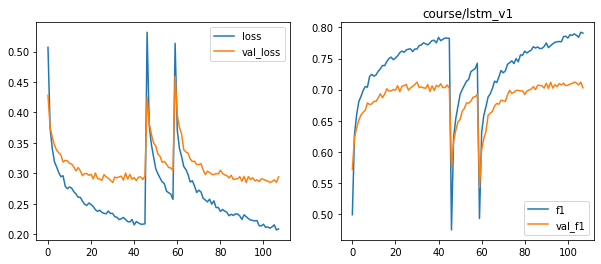

In [10]:
plot_results("course/lstm_v1")

## Parameter Tunning

So the model is reaching 0.85 in training and 0.7 in test dataset, much more that the ExtraTree classifier, so the model is working for the problem. 
However, it seems the model is overfitting, the train/test f1 curves are diverging showing that the models is performing well around the training data and loosing generalization capacity.
Lets apply more regularization parameters to try to improve the performance on the test dataset.

In [12]:
vocab_size = len(np.unique(sample[:, 11])) # number of different crops, 26
sequence_length=8
embedding_size=20 # how many dimesions we want o use to represent each crop code

initializer = tf.keras.initializers.Identity()
model = Sequential()
model.add(Embedding(vocab_size, embedding_size,
                    embeddings_initializer=initializer,
                    input_length=sequence_length))
model.add(BatchNormalization())
model.add(LSTM(64, dropout=0.3, recurrent_dropout=0.4))
model.add(BatchNormalization())
model.add(Dense(vocab_size, activation="relu"))

model.compile(**training_params)

In [13]:
folder = train_evaluate_model(model, "lstm_v2", X_train, y_train, X_test, y_test)

Epoch 1/100
785/785 - 18s - loss: 0.5549 - f1: 0.4503 - val_loss: 0.4154 - val_f1: 0.5847
Epoch 2/100
785/785 - 18s - loss: 0.3909 - f1: 0.6101 - val_loss: 0.3675 - val_f1: 0.6302
Epoch 3/100
785/785 - 17s - loss: 0.3547 - f1: 0.6451 - val_loss: 0.3488 - val_f1: 0.6484
Epoch 4/100
785/785 - 17s - loss: 0.3365 - f1: 0.6632 - val_loss: 0.3383 - val_f1: 0.6572
Epoch 5/100
785/785 - 17s - loss: 0.3130 - f1: 0.6867 - val_loss: 0.3259 - val_f1: 0.6716
Epoch 6/100
785/785 - 17s - loss: 0.3131 - f1: 0.6865 - val_loss: 0.3209 - val_f1: 0.6761
Epoch 7/100
785/785 - 17s - loss: 0.2968 - f1: 0.7027 - val_loss: 0.3159 - val_f1: 0.6812
Epoch 8/100
785/785 - 17s - loss: 0.2966 - f1: 0.7026 - val_loss: 0.3121 - val_f1: 0.6850
Epoch 9/100
785/785 - 17s - loss: 0.2888 - f1: 0.7107 - val_loss: 0.3084 - val_f1: 0.6887
Epoch 10/100
785/785 - 22s - loss: 0.2844 - f1: 0.7152 - val_loss: 0.3077 - val_f1: 0.6895
Epoch 11/100
785/785 - 18s - loss: 0.2828 - f1: 0.7172 - val_loss: 0.3043 - val_f1: 0.6927
Epoch 12

Best f1-score on test dataset: **0.7176**

Other experiments have been carried out to see how different aspects of architecture influence:
* Embedding dimension size: 20.
* Number of cells: 256.
* Number of LSTM layers: 1 layer. It seems that the depth of the lstm cells improves the ability to understand the context in long statements. In our case, being a series of only 8 steps, increasing the number of layers does not improve performance.
* LSTM layer regularizers: as mentioned [here](https://machinelearningmastery.com/use-weight-regularization-lstm-networks-time-series-forecasting/), the layer performs better using l2 in recurrent_regularization parameter with a value of 0.001.
    

Results file: course/lstm_v2
Last 10 records avg: 
epoch       49.500000
f1           0.759437
loss         0.240019
val_f1       0.712693
val_loss     0.284562
dtype: float64


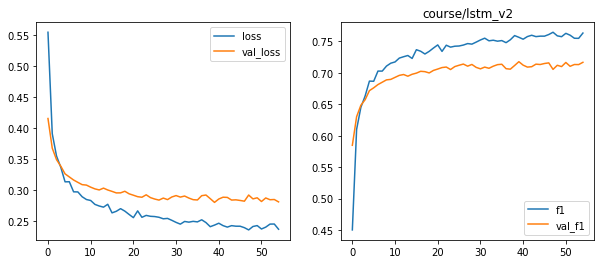

In [15]:
plot_results("course/lstm_v2")

The learning curves look better, the train and test curves are closer, but it seems the model can be improved adding regularization to get better results in the test dataset.

A **bayesian optimization process** has been run on this model using the [bayesian-optimization library](https://pypi.org/project/bayesian-optimization/). This tecnhique leeds to the optimal parameter solution. The procedure is high time consuming, if you are interested in the code, take a look at src/optimize.py file.


In [19]:
vocab_size = len(np.unique(sample[:, 11])) # number of different crops, 26
sequence_length=8
embedding_size=20 # how many dimesions we want o use to represent each crop code

initializer = tf.keras.initializers.Identity()
model = Sequential()
model.add(Embedding(vocab_size, embedding_size,
                    embeddings_initializer=initializer,
                    input_length=sequence_length))
model.add(BatchNormalization())
model.add(LSTM(256, dropout=0.3, recurrent_dropout=0.4, return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(128, dropout=0.3, recurrent_dropout=0.4))
model.add(BatchNormalization())
model.add(Dense(vocab_size, activation="relu"))

model.compile(**training_params)
folder = train_evaluate_model(model, "lstm_v3", X_train, y_train, X_test, y_test)

Epoch 1/100
785/785 - 33s - loss: 0.4859 - f1: 0.5171 - val_loss: 0.4002 - val_f1: 0.5977
Epoch 2/100
785/785 - 32s - loss: 0.3873 - f1: 0.6126 - val_loss: 0.3666 - val_f1: 0.6309
Epoch 3/100
785/785 - 32s - loss: 0.3533 - f1: 0.6464 - val_loss: 0.3468 - val_f1: 0.6503
Epoch 4/100
785/785 - 32s - loss: 0.3243 - f1: 0.6755 - val_loss: 0.3273 - val_f1: 0.6704
Epoch 5/100
785/785 - 33s - loss: 0.2976 - f1: 0.7019 - val_loss: 0.3211 - val_f1: 0.6758
Epoch 6/100
785/785 - 33s - loss: 0.2939 - f1: 0.7057 - val_loss: 0.3101 - val_f1: 0.6867
Epoch 7/100
785/785 - 32s - loss: 0.2841 - f1: 0.7154 - val_loss: 0.3052 - val_f1: 0.6924
Epoch 8/100
785/785 - 31s - loss: 0.2765 - f1: 0.7231 - val_loss: 0.3027 - val_f1: 0.6948
Epoch 9/100
785/785 - 32s - loss: 0.2669 - f1: 0.7328 - val_loss: 0.2990 - val_f1: 0.6981
Epoch 10/100
785/785 - 31s - loss: 0.2578 - f1: 0.7417 - val_loss: 0.3006 - val_f1: 0.6970
Epoch 11/100
785/785 - 31s - loss: 0.2597 - f1: 0.7398 - val_loss: 0.3002 - val_f1: 0.6970
Epoch 12

Best f1-score on test dataset: **0.7183**

Results file: course/lstm_v3
Last 10 records avg: 
epoch       45.500000
f1           0.775751
loss         0.223662
val_f1       0.712375
val_loss     0.284879
dtype: float64


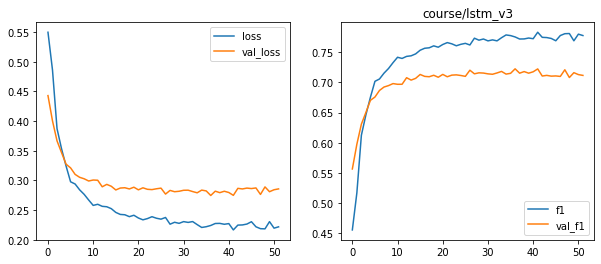

In [21]:
plot_results("course/lstm_v3")

The train curve is higher than than the 1 layer model, so the model seems to be able to learn more patterns. The tes curve slightly improves the 1-layer model, but the test curve is also stuck in a plateau around 0.71 value.

To try to get out of this plain, we use the keras callback ReduceLROnPlateau, it will reduce the learning rate when the plateau is reached to improve the training.


In [28]:
callbacks = []    
callbacks.append(CSVLogger('{}/training_history.csv'.format(folder), append=True, separator=';'))
stopper = keras.callbacks.EarlyStopping(monitor="val_f1",
    # "no longer improving" being defined as "no better than 1e-3 less"
    min_delta=0.001,
    mode="max",
    # "no longer improving" being further defined as "for at least 8 epochs"
    patience=15, verbose=1)
callbacks.append(stopper)
lrReducer = ReduceLROnPlateau(monitor='val_f1', factor=0.2, model="max", patience=7, verbose=1, min_lr=0)
callbacks.append(lrReducer)

folder = train_evaluate_model(model, "lstm_v3_l4", X_train, y_train, X_test, y_test, callbacks=callbacks)

Epoch 1/100
785/785 - 31s - loss: 0.2246 - f1: 0.7749 - val_loss: 0.2831 - val_f1: 0.7140 - lr: 0.0010
Epoch 2/100
785/785 - 31s - loss: 0.2184 - f1: 0.7811 - val_loss: 0.2807 - val_f1: 0.7168 - lr: 0.0010
Epoch 3/100
785/785 - 31s - loss: 0.2214 - f1: 0.7782 - val_loss: 0.2776 - val_f1: 0.7198 - lr: 0.0010
Epoch 4/100
785/785 - 32s - loss: 0.2175 - f1: 0.7821 - val_loss: 0.2802 - val_f1: 0.7171 - lr: 0.0010
Epoch 5/100
785/785 - 29s - loss: 0.2218 - f1: 0.7780 - val_loss: 0.2772 - val_f1: 0.7200 - lr: 0.0010
Epoch 6/100
785/785 - 29s - loss: 0.2232 - f1: 0.7763 - val_loss: 0.2809 - val_f1: 0.7164 - lr: 0.0010
Epoch 7/100
785/785 - 29s - loss: 0.2179 - f1: 0.7815 - val_loss: 0.2808 - val_f1: 0.7161 - lr: 0.0010
Epoch 8/100

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
785/785 - 30s - loss: 0.2206 - f1: 0.7791 - val_loss: 0.2800 - val_f1: 0.7173 - lr: 0.0010
Epoch 9/100
785/785 - 29s - loss: 0.2180 - f1: 0.7816 - val_loss: 0.2798 - val_f1: 0.7175 - lr

It improved the model f1-score on test dataset from **0.7183** to **0.7228** not very much.

/home/gus/workspaces/wpy/venvs/mathor/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Confusion matrix, without normalization


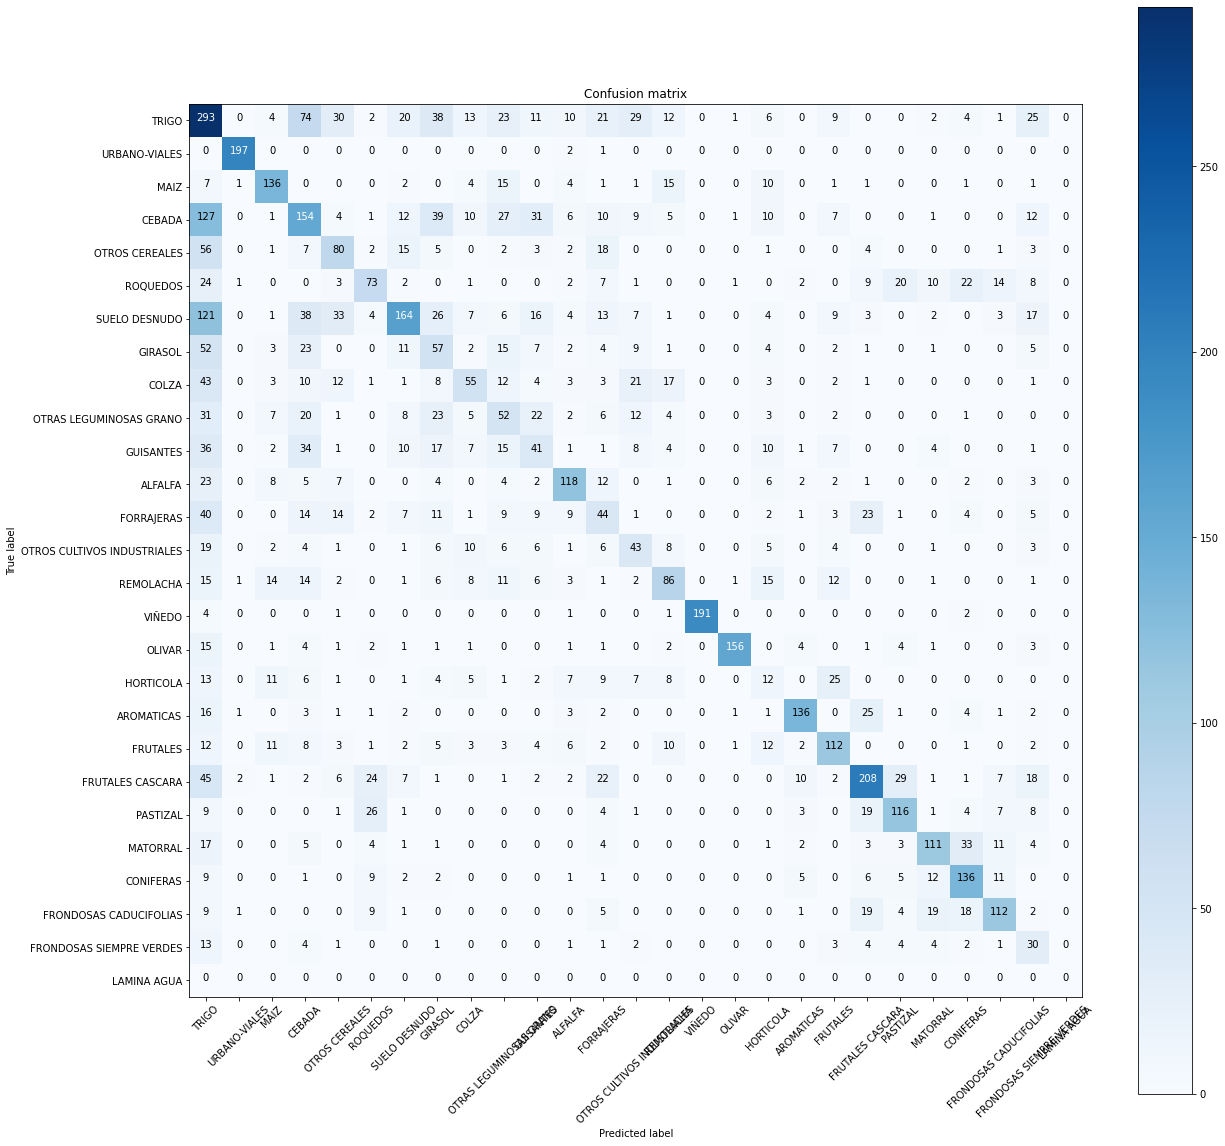

In [55]:
from sklearn.metrics import classification_report, confusion_matrix
from recipes import plot_confusion_matrix

y_pred = model.predict(X_test)

class_test = np.argmax(y_test, axis=1)
class_predicted = np.argmax(y_pred, axis=1)

crop_names = df_crops["description"].values.tolist()
crop_list = df_crops["idx"].values.tolist()

classes = crop_list
cfm = confusion_matrix(class_test, class_predicted, classes)
# plot_confusion_matrix(cfm, classes=crop_names, figsize=(20, 20), output_file="{}/cfm.png".format(folder))
plot_confusion_matrix(cfm, figsize=(20, 20), classes=crop_names)#, classes= crop_names)